# Homework #2 --- Part #1

## Mohammad Azimpour, 810197657

In [1]:
from amalearn.environment import *
from amalearn.agent import *
from amalearn.reward import *
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

### Question #1

#### Part #1-A

In [2]:
class Reward4(RewardBase):
    def __init__(self, mean1, std1, p1, mean2, std2, p2):
        super(Reward4, self).__init__()
        self.reward1 = GaussianReward(mean1, std1)
        self.reward2 = GaussianReward(mean2, std2)
        self.p1 = p1
        self.p2 = p2
    
    def get_reward(self):
        return np.random.choice([self.reward1.get_reward(), self.reward2.get_reward()], p=[self.p1, self.p2])

In [3]:
class EpsilonGreedyPolicy():
    def __init__(self, epsilon):
        self.epsilon = epsilon
    
    def get_action(self, actions, expected_rewards):
        if (np.random.random() <= self.epsilon):
            return np.argmax(expected_rewards)
        else:
            return random.randrange(len(expected_rewards))
    
    def update_expected_rewards(self, expected_rewards, action, reward, action_trials):
        expected_rewards[action] = (expected_rewards[action] * action_trials + reward)/(float(action_trials + 1))
        return expected_rewards

In [27]:
class EpsilonGreedyAgent(AgentBase):
    def __init__(self, id, env, epsilon):
        super(EpsilonGreedyAgent, self).__init__(id, env)
        self.policy = EpsilonGreedyPolicy(epsilon)
        self.actions = self.environment.available_actions()
        self.expected_rewards = [0.0 for col in range(self.actions)]
        self.action_trials = [0 for col in range(self.actions)]
        self.rewards_average = 0.0
        self.rewards = []
    
    def take_action(self) -> (object, float, bool, object):
        action = self.policy.get_action(self.actions, self.expected_rewards)
        obs, r, d, i = self.environment.step(action)
        self.rewards.append(r)
        self.rewards_average = (self.rewards_average * np.sum(self.action_trials) + r) / (np.sum(self.action_trials) + 1)
        self.expected_rewards = self.policy.update_expected_rewards(self.expected_rewards, action, r, self.action_trials[action])
        self.action_trials[action] = self.action_trials[action] + 1
        #print(obs, r, d, i)
        #self.environment.render()
        return obs, r, d, i
    
    def reset(self):
        self.expected_rewards = [0.0 for col in range(self.actions)]
        self.action_trials = [0 for col in range(self.actions)]
        self.rewards_average = 0.0
        self.rewards = []
    
    def get_rewards_average(self):
        return self.rewards_average
    
    def get_std(self):
        return np.std(self.rewards, ddof=1)

    def get_action_trials(self):
        return self.action_trials

In [5]:
rewards = []
rewards.append(GaussianReward(7, 1))
rewards.append(GaussianReward(5, 2))
rewards.append(GaussianReward(4, 1))
rewards.append(Reward4(5, 2, 0.7, -5, 1, 0.3))

env = MutliArmedBanditEnvironment(rewards, 1000, '1')

In [6]:
epsilon_greedy_agent = EpsilonGreedyAgent('1', env, 0.2)
eg_rewards_average = []

for run in range(20):
    for trial in range(1000):
        epsilon_greedy_agent.take_action()
    eg_rewards_average.append(epsilon_greedy_agent.get_rewards_average())
    env.reset()
    epsilon_greedy_agent.reset()

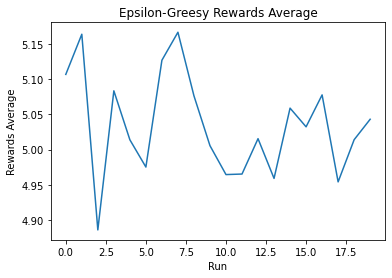

In [7]:
plt.plot(eg_rewards_average)
plt.xlabel("Run")
plt.ylabel("Rewards Average")
plt.title("Epsilon-Greesy Rewards Average")
plt.savefig("figs/11A-EG.jpg")
plt.show()

In [8]:
class GradiantBasedPolicy():
    def __init__(self, lr):
        self.lr = lr
        self.probs = []
    
    def softmax(self, actions, preferences):
        self.probs = []
        #_preference = preferences - np.max(preferences)
        #self.probs = np.exp(_preference) / np.sum((_preference), axis=0)
        for i in range(actions):
            self.probs.append(np.exp(preferences[i] - np.max(preferences)))
        self.probs /= np.sum(self.probs)
        return self.probs
    
    def get_action(self, actions, preferences):
        return np.random.choice(actions, p=self.softmax(actions, preferences))
    
    def update_preferences(self, preferences, actions, action, reward, rewards_average):
        for i in range(actions):
            if action == i:
                preferences[action] = preferences[action] + self.lr * (reward - rewards_average) * (1 - self.probs[action])
            else:
                preferences[action] = preferences[action] + self.lr * (reward - rewards_average) * (self.probs[action])
        return preferences

In [9]:
class GradiantBasedAgent(AgentBase):
    def __init__(self, id, env, lr):
        super(GradiantBasedAgent, self).__init__(id, env)
        self.actions = self.environment.available_actions()
        self.action_trials = [0 for col in range(self.actions)]
        self.preferences = [0.0 for col in range(self.actions)]
        self.rewards_average = 0.0
        self.lr = lr
        self.policy = GradiantBasedPolicy(lr)
    
    def take_action(self) -> (object, float, bool, object):
        action = self.policy.get_action(self.actions, self.preferences)
        obs, r, d, i = self.environment.step(action)
        self.rewards_average = (self.rewards_average * np.sum(self.action_trials) + r) / (np.sum(self.action_trials) + 1)
        self.preferences = self.policy.update_preferences(self.preferences, self.actions, action, r, self.rewards_average)
        self.action_trials[action] = self.action_trials[action] + 1
        #self.environment.render()
        return obs, r, d, i
    
    def reset(self):
        self.action_trials = [0 for col in range(self.actions)]
        self.preferences = [0.0 for col in range(self.actions)]
        self.rewards_average = 0.0
    
    def get_rewards_average(self):
        return self.rewards_average

In [116]:
gradiant_based_agent = GradiantBasedAgent('1', env, 0.1)
gb_rewards_average = []

for run in range(20):
    for trial in range(1000):
        gradiant_based_agent.take_action()
    gb_rewards_average.append(gradiant_based_agent.get_rewards_average())
    env.reset()
    gradiant_based_agent.reset()

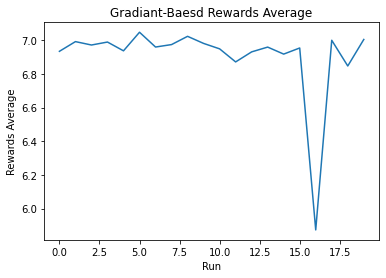

In [117]:
plt.plot(gb_rewards_average)
plt.xlabel("Run")
plt.ylabel("Rewards Average")
plt.title("Gradiant-Baesd Rewards Average")
plt.savefig("figs/11A-GB.jpg")
plt.show()

In [7]:
class UCBPolicy():
    def __init__(self, c):
        self.c = c
            
    def get_action(self, actions, action_trials, ucbs):
        _ucbs = ucbs + self.c * np.sqrt(np.log((np.sum(action_trials) + 1) / action_trials))
        return np.argmax(_ucbs)

    def update_ucbs(self, ucbs, actions, action, action_trials, reward):
        ucb = ucbs[action]
        _ucb = ((action_trials[action]) / float(action_trials[action] + 1)) * ucb + (1 / float(action_trials[action]+1)) * reward
        ucbs[action] = _ucb
        return ucbs

In [8]:
class UCBAgent(AgentBase):
    def __init__(self, id, env, c):
        super(UCBAgent, self).__init__(id, env)
        self.actions = self.environment.available_actions()
        self.action_trials = [0 for col in range(self.actions)]
        self.ucbs = [0.0 for col in range(self.actions)]
        self.rewards_average = 0.0
        self.c = c
        self.policy = UCBPolicy(c)
    
    def take_action(self) -> (object, float, bool, object):
        action = self.policy.get_action(self.actions, self.action_trials, self.ucbs)
        obs, r, d, i = self.environment.step(action)
        self.rewards_average = (self.rewards_average * np.sum(self.action_trials) + r) / (np.sum(self.action_trials) + 1)
        self.ucbs = self.policy.update_ucbs(self.ucbs, self.actions, action, self.action_trials, r)
        self.action_trials[action] = self.action_trials[action] + 1
        #self.environment.render()
        return obs, r, d, i
    
    def reset(self):
        self.action_trials = [0 for col in range(self.actions)]
        self.ucbs = [0.0 for col in range(self.actions)]
        self.rewards_average = 0.0
    
    def get_rewards_average(self):
        return self.rewards_average
    
    def get_action_trials(self):
        return self.action_trials

In [118]:
ucb_agent = UCBAgent('1', env, 0.1)
ucb_rewards_average = []

for run in range(20):
    for trial in range(1000):
        ucb_agent.take_action()
    ucb_rewards_average.append(ucb_agent.get_rewards_average())
    env.reset()
    ucb_agent.reset()

<ipython-input-12-121ba6b58a83>:6: RuntimeWarning: divide by zero encountered in true_divide
  _ucbs = ucbs + self.c * np.sqrt(np.log((np.sum(action_trials) + 1) / action_trials))


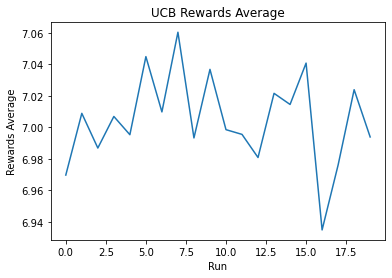

In [119]:
plt.plot(ucb_rewards_average)
plt.xlabel("Run")
plt.ylabel("Rewards Average")
plt.title("UCB Rewards Average")
plt.savefig("figs/11A-UCB.jpg")
plt.show()

#### Part #1-B

In [101]:
class UtilityBasedEpsilonGreedyAgent(AgentBase):
    def __init__(self, id, env, epsilon, alpha, beta, gama):
        super(UtilityBasedEpsilonGreedyAgent, self).__init__(id, env)
        self.policy = EpsilonGreedyPolicy(epsilon)
        self.actions = self.environment.available_actions()
        self.expected_utils = [float(alpha) for col in range(self.actions)]
        self.action_trials = [0 for col in range(self.actions)]
        self.utils_average = 0.0
        self.alpha = alpha
        self.beta = beta
        self.gama = gama
    
    def take_action(self) -> (object, float, bool, object):
        action = self.policy.get_action(self.actions, self.expected_utils)
        obs, r, d, i = self.environment.step(action)
        if r >= 0:
            u = (r ** self.alpha)
        else:
            u = - self.gama * (np.abs(r) ** self.beta)
        self.utils_average = (self.utils_average * np.sum(self.action_trials) + u) / (np.sum(self.action_trials) + 1)
        self.expected_utils = self.policy.update_expected_rewards(self.expected_utils, action, u, self.action_trials[action])
        self.action_trials[action] = self.action_trials[action] + 1
        #print(obs, r, d, i)
        #self.environment.render()
        return obs, u, d, i
    
    def reset(self):
        self.expected_utils = [float(alpha) for col in range(self.actions)]
        self.action_trials = [0 for col in range(self.actions)]
        self.utils_average = 0.0
    
    def get_utils_average(self):
        return self.utils_average

In [102]:
class UtilityBasedGradiantBasedAgent(AgentBase):
    def __init__(self, id, env, lr, alpha, beta, gama):
        super(UtilityBasedGradiantBasedAgent, self).__init__(id, env)
        self.actions = self.environment.available_actions()
        self.action_trials = [0 for col in range(self.actions)]
        self.preferences = [0.0 for col in range(self.actions)]
        self.utils_average = 0.0
        self.lr = lr
        self.policy = GradiantBasedPolicy(lr)
        self.alpha = alpha
        self.beta = beta
        self.gama = gama
    
    def take_action(self) -> (object, float, bool, object):
        action = self.policy.get_action(self.actions, self.preferences)
        obs, r, d, i = self.environment.step(action)
        if r >= 0:
            u = (r ** self.alpha)
        else:
            u = - self.gama * (np.abs(r) ** self.beta)
        self.utils_average = (self.utils_average * np.sum(self.action_trials) + u) / (np.sum(self.action_trials) + 1)
        self.preferences = self.policy.update_preferences(self.preferences, self.actions, action, u, self.utils_average)
        self.action_trials[action] = self.action_trials[action] + 1
        #self.environment.render()
        return obs, u, d, i
    
    def reset(self):
        self.action_trials = [0 for col in range(self.actions)]
        self.preferences = [0.0 for col in range(self.actions)]
        self.utils_average = 0.0
    
    def get_utils_average(self):
        return self.utils_average

In [103]:
class UtilityBasedUCBAgent(AgentBase):
    def __init__(self, id, env, c, alpha, beta, gama):
        super(UtilityBasedUCBAgent, self).__init__(id, env)
        self.actions = self.environment.available_actions()
        self.action_trials = [0 for col in range(self.actions)]
        self.ucbs = [0.0 for col in range(self.actions)]
        self.utils_average = 0.0
        self.c = c
        self.policy = UCBPolicy(c)
        self.alpha = alpha
        self.beta = beta
        self.gama = gama
    
    def take_action(self) -> (object, float, bool, object):
        action = self.policy.get_action(self.actions, self.action_trials, self.ucbs)
        obs, r, d, i = self.environment.step(action)
        if r >= 0:
            u = (r ** self.alpha)
        else:
            u = - self.gama * (np.abs(r) ** self.beta)
        self.utils_average = (self.utils_average * np.sum(self.action_trials) + u) / (np.sum(self.action_trials) + 1)
        self.ucbs = self.policy.update_ucbs(self.ucbs, self.actions, action, self.action_trials, u)
        self.action_trials[action] = self.action_trials[action] + 1
        #self.environment.render()
        return obs, u, d, i
    
    def reset(self):
        self.action_trials = [0 for col in range(self.actions)]
        self.ucbs = [0.0 for col in range(self.actions)]
        self.utils_average = 0.0
    
    def get_utils_average(self):
        return self.utils_average

In [162]:
alpha = 1
beta = 1
gamma = 1

ub_epsilon_greedy_agent = UtilityBasedEpsilonGreedyAgent('1', env, 0.2, alpha, beta, gamma)
ub_epsilon_greedy_utils_average = []
ub_gradiant_based_agent = UtilityBasedGradiantBasedAgent('1', env, 0.1, alpha, beta, gamma)
ub_gradiant_based_utils_average = []
ub_ucb_agent = UtilityBasedUCBAgent('1', env, 0.1, alpha, beta, gamma)
ub_ucb_utils_average = []

for i in range(1000):
    ub_epsilon_greedy_agent.take_action()
    ub_epsilon_greedy_utils_average.append(ub_epsilon_greedy_agent.get_utils_average())
env.reset()

for j in range(1000): 
    ub_gradiant_based_agent.take_action()
    ub_gradiant_based_utils_average.append(ub_gradiant_based_agent.get_utils_average())
env.reset()

for k in range(1000): 
    ub_ucb_agent.take_action()
    ub_ucb_utils_average.append(ub_ucb_agent.get_utils_average())
env.reset()

<ipython-input-12-121ba6b58a83>:6: RuntimeWarning: divide by zero encountered in true_divide
  _ucbs = ucbs + self.c * np.sqrt(np.log((np.sum(action_trials) + 1) / action_trials))


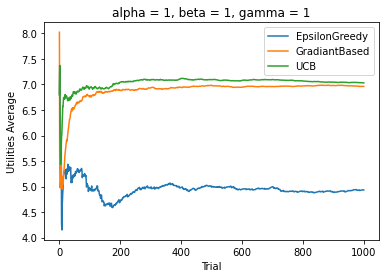

In [163]:
plt.plot(ub_epsilon_greedy_utils_average)
plt.plot(ub_gradiant_based_utils_average)
plt.plot(ub_ucb_utils_average)
plt.xlabel("Trial")
plt.ylabel("Utilities Average")
plt.title("alpha = 1, beta = 1, gamma = 1")
plt.legend(["EpsilonGreedy", "GradiantBased", "UCB"])
plt.savefig("figs/11B-111.jpg")
plt.show()

In [170]:
alpha = 1
beta = 1
gamma = 2

ub_epsilon_greedy_agent = UtilityBasedEpsilonGreedyAgent('1', env, 0.2, alpha, beta, gamma)
ub_epsilon_greedy_utils_average = []
ub_gradiant_based_agent = UtilityBasedGradiantBasedAgent('1', env, 0.1, alpha, beta, gamma)
ub_gradiant_based_utils_average = []
ub_ucb_agent = UtilityBasedUCBAgent('1', env, 0.1, alpha, beta, gamma)
ub_ucb_utils_average = []

for i in range(1000):
    ub_epsilon_greedy_agent.take_action()
    ub_epsilon_greedy_utils_average.append(ub_epsilon_greedy_agent.get_utils_average())
env.reset()

for j in range(1000): 
    ub_gradiant_based_agent.take_action()
    ub_gradiant_based_utils_average.append(ub_gradiant_based_agent.get_utils_average())
env.reset()

for k in range(1000): 
    ub_ucb_agent.take_action()
    ub_ucb_utils_average.append(ub_ucb_agent.get_utils_average())
env.reset()

<ipython-input-12-121ba6b58a83>:6: RuntimeWarning: divide by zero encountered in true_divide
  _ucbs = ucbs + self.c * np.sqrt(np.log((np.sum(action_trials) + 1) / action_trials))


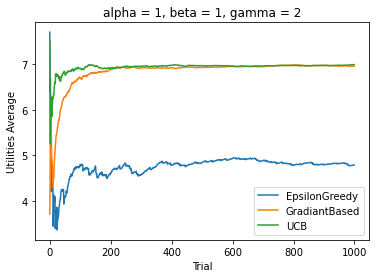

In [171]:
plt.plot(ub_epsilon_greedy_utils_average)
plt.plot(ub_gradiant_based_utils_average)
plt.plot(ub_ucb_utils_average)
plt.xlabel("Trial")
plt.ylabel("Utilities Average")
plt.title("alpha = 1, beta = 1, gamma = 2")
plt.legend(["EpsilonGreedy",  "GradiantBased", "UCB"])
plt.savefig("figs/11B-112.jpg")
plt.show()

In [240]:
alpha = 1
beta = 2
gamma = 1

ub_epsilon_greedy_agent = UtilityBasedEpsilonGreedyAgent('1', env, 0.2, alpha, beta, gamma)
ub_epsilon_greedy_utils_average = []
ub_gradiant_based_agent = UtilityBasedGradiantBasedAgent('1', env, 0.1, alpha, beta, gamma)
ub_gradiant_based_utils_average = []
ub_ucb_agent = UtilityBasedUCBAgent('1', env, 0.1, alpha, beta, gamma)
ub_ucb_utils_average = []

for i in range(1000):
    ub_epsilon_greedy_agent.take_action()
    ub_epsilon_greedy_utils_average.append(ub_epsilon_greedy_agent.get_utils_average())
env.reset()

for j in range(1000): 
    ub_gradiant_based_agent.take_action()
    ub_gradiant_based_utils_average.append(ub_gradiant_based_agent.get_utils_average())
env.reset()

for k in range(1000): 
    ub_ucb_agent.take_action()
    ub_ucb_utils_average.append(ub_ucb_agent.get_utils_average())
env.reset()

<ipython-input-12-121ba6b58a83>:6: RuntimeWarning: divide by zero encountered in true_divide
  _ucbs = ucbs + self.c * np.sqrt(np.log((np.sum(action_trials) + 1) / action_trials))


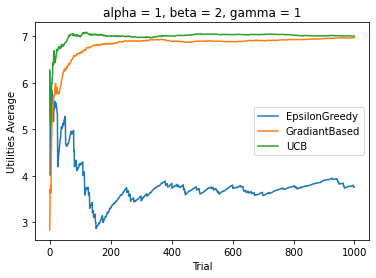

In [241]:
plt.plot(ub_epsilon_greedy_utils_average)
plt.plot(ub_gradiant_based_utils_average)
plt.plot(ub_ucb_utils_average)
plt.xlabel("Trial")
plt.ylabel("Utilities Average")
plt.title("alpha = 1, beta = 2, gamma = 1")
plt.legend(["EpsilonGreedy",  "GradiantBased", "UCB"])
plt.savefig("figs/11B-121.jpg")
plt.show()

In [262]:
alpha = 2
beta = 1
gamma = 1

ub_epsilon_greedy_agent = UtilityBasedEpsilonGreedyAgent('1', env, 0.2, alpha, beta, gamma)
ub_epsilon_greedy_utils_average = []
ub_gradiant_based_agent = UtilityBasedGradiantBasedAgent('1', env, 0.1, alpha, beta, gamma)
ub_gradiant_based_utils_average = []
ub_ucb_agent = UtilityBasedUCBAgent('1', env, 0.1, alpha, beta, gamma)
ub_ucb_utils_average = []

for i in range(1000):
    ub_epsilon_greedy_agent.take_action()
    ub_epsilon_greedy_utils_average.append(ub_epsilon_greedy_agent.get_utils_average())
env.reset()

for j in range(1000):
    ub_gradiant_based_agent.take_action()
    ub_gradiant_based_utils_average.append(ub_gradiant_based_agent.get_utils_average())
env.reset()

for k in range(1000): 
    ub_ucb_agent.take_action()
    ub_ucb_utils_average.append(ub_ucb_agent.get_utils_average())
env.reset()

<ipython-input-12-121ba6b58a83>:6: RuntimeWarning: divide by zero encountered in true_divide
  _ucbs = ucbs + self.c * np.sqrt(np.log((np.sum(action_trials) + 1) / action_trials))


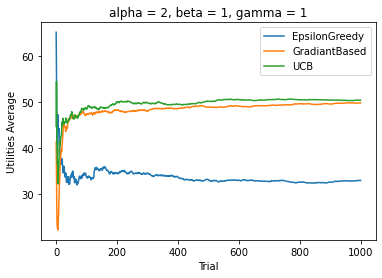

In [263]:
plt.plot(ub_epsilon_greedy_utils_average)
plt.plot(ub_gradiant_based_utils_average)
plt.plot(ub_ucb_utils_average)
plt.xlabel("Trial")
plt.ylabel("Utilities Average")
plt.title("alpha = 2, beta = 1, gamma = 1")
plt.legend(["EpsilonGreedy",  "GradiantBased", "UCB"])
plt.savefig("figs/11B-211.jpg")
plt.show()

#### Part #2-A

In [266]:
class VariableEpsilonGreedyPolicy():
    def __init__(self):
        self.n = 0
    
    def get_action(self, actions, expected_rewards):
        self.n = self.n + 1
        epsilon = 1 - 1/self.n
        if (np.random.random() <= epsilon):
            return np.argmax(expected_rewards)
        else:
            return random.randrange(len(expected_rewards))
    
    def update_expected_rewards(self, expected_rewards, action, reward, action_trials):
        expected_rewards[action] = (expected_rewards[action] * action_trials + reward)/(float(action_trials + 1))
        return expected_rewards
    
    def reset(self):
        self.n = 0

In [267]:
class VariableEpsilonGreedyAgent(AgentBase):
    def __init__(self, id, env):
        super(VariableEpsilonGreedyAgent, self).__init__(id, env)
        self.policy = VariableEpsilonGreedyPolicy()
        self.actions = self.environment.available_actions()
        self.expected_rewards = [0.0 for col in range(self.actions)]
        self.action_trials = [0 for col in range(self.actions)]
        self.rewards_average = 0.0
    
    def take_action(self) -> (object, float, bool, object):
        action = self.policy.get_action(self.actions, self.expected_rewards)
        obs, r, d, i = self.environment.step(action)
        self.rewards_average = (self.rewards_average * np.sum(self.action_trials) + r) / (np.sum(self.action_trials) + 1)
        self.expected_rewards = self.policy.update_expected_rewards(self.expected_rewards, action, r, self.action_trials[action])
        self.action_trials[action] = self.action_trials[action] + 1
        #print(obs, r, d, i)
        #self.environment.render()
        return obs, r, d, i
    
    def reset(self):
        self.expected_rewards = [0.0 for col in range(self.actions)]
        self.action_trials = [0 for col in range(self.actions)]
        self.rewards_average = 0.0
        self.policy.reset()
    
    def get_rewards_average(self):
        return self.rewards_average

In [276]:
high_epsilon_greedy_agent = EpsilonGreedyAgent('1', env, 0.7)
heg_rewards_average = []
low_epsilon_greedy_agent = EpsilonGreedyAgent('1', env, 0.3)
leg_rewards_average = []
var_epsilon_greedy_agent = VariableEpsilonGreedyAgent('1', env)
veg_rewards_average = []

for i in range(1000):
    high_epsilon_greedy_agent.take_action()
    heg_rewards_average.append(high_epsilon_greedy_agent.get_rewards_average())
env.reset()

for j in range(1000): 
    low_epsilon_greedy_agent.take_action()
    leg_rewards_average.append(low_epsilon_greedy_agent.get_rewards_average())
env.reset()

for k in range(1000): 
    var_epsilon_greedy_agent.take_action()
    veg_rewards_average.append(var_epsilon_greedy_agent.get_rewards_average())
env.reset()

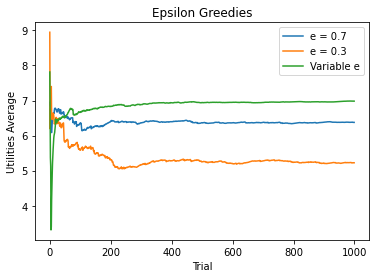

In [277]:
plt.plot(heg_rewards_average)
plt.plot(leg_rewards_average)
plt.plot(veg_rewards_average)
plt.xlabel("Trial")
plt.ylabel("Utilities Average")
plt.title("Epsilon Greedies")
plt.legend(["e = 0.7",  "e = 0.3", "Variable e"])
plt.savefig("figs/12A.jpg")
plt.show()

#### Part #2-B-4

In [13]:
class RandomAgent(AgentBase):
    def __init__(self, id, env):
        super(RandomAgent, self).__init__(id, env)
        self.actions = self.environment.available_actions()
        self.action_trials = [0 for col in range(self.actions)]
        self.rewards_average = 0.0
    
    def take_action(self) -> (object, float, bool, object):
        action = np.random.choice(self.actions)
        obs, r, d, i = self.environment.step(action)
        self.action_trials[action] = self.action_trials[action] + 1
        self.rewards_average = (self.rewards_average * np.sum(self.action_trials) + r) / (np.sum(self.action_trials) + 1)
        #print(obs, r, d, i)
        #self.environment.render()
        return obs, r, d, i
    
    def reset(self):
        self.action_trials = 0
        self.rewards_average = 0.0
    
    def get_rewards_average(self):
        return self.rewards_average

    def get_action_trials(self):
        return self.action_trials

In [104]:
class OUCBPolicy():
    def __init__(self, betas):
        self.betas = betas
    
    def theta(self, ats, trial, action_trials):
        diff = (np.array(ats) - np.array(action_trials)) / (trial + 1)
        diff = [(i if i > 0 else 0) for i in diff]
        return np.array(diff)
    
    def get_action(self, actions, preferences, trial, action_trials, ats):
        if (trial + 1) < actions:
            return trial
        else:
            terms = []
            terms.append(self.betas[1] * self.theta(ats[0], trial, action_trials))
            terms.append(self.betas[2] * self.theta(ats[1], trial, action_trials))
            terms.append(self.betas[3] * self.theta(ats[2], trial, action_trials))
            preferences = preferences + np.sqrt((2 * np.log(trial + 1) / action_trials)) * (np.sum(terms) + self.betas[0])
            return np.argmax(preferences)

In [105]:
class OUCBAgent(AgentBase):
    def __init__(self, id, env, betas):
        super(OUCBAgent, self).__init__(id, env)
        self.rewards = []
        self.rewards_average = 0.0
        self.actions = self.environment.available_actions()
        self.action_trials = [0 for col in range(self.actions)]
        self.preferences = [0 for col in range(self.actions)]
        self.betas = betas
        self.policy = OUCBPolicy(betas)
    
    def take_action(self, trial, ats) -> (object, float, bool, object):
        action = self.policy.get_action(self.actions, self.preferences, trial, self.action_trials, ats)
        obs, r, d, i = self.environment.step(action)
        self.rewards.append(r)
        self.rewards_average = (self.rewards_average * np.sum(self.action_trials) + r) / (np.sum(self.action_trials) + 1)
        self.action_trials[action] = self.action_trials[action] + 1
        #self.environment.render()
        return obs, r, d, i
    
    def reset(self):
        self.action_trials = [0 for col in range(self.actions)]
        self.preferences = [0.0 for col in range(self.actions)]
        self.rewards = []
    
    def get_rewards_average(self):
        return self.rewards_average
    
    def get_std(self):
        return np.std(self.rewards, ddof=1)

    def get_action_trials(self):
        return self.action_trials

In [108]:
rewards = []
rewards.append(GaussianReward(7, 1))
rewards.append(GaussianReward(5, 2))
rewards.append(GaussianReward(4, 1))
rewards.append(Reward4(5, 2, 0.7, -5, 1, 0.3))

env = MutliArmedBanditEnvironment(rewards, 5000, '1')

target1 = EpsilonGreedyAgent('1', env, 0.3)
target2 = UCBAgent('1', env, 2)
target3 = RandomAgent('1', env)
cheater_mr_nobody = OUCBAgent('1', env, [0.2, 0.2, 0.5, 0.1])
self_mr_nobody = EpsilonGreedyAgent('1', env, 0.2)

cheater_mr_nobody_rewards_average = []
cheater_mr_nobody_errors = []
self_mr_nobody_rewards_average = []
self_mr_nobody_errors = []

for trial in range(1000):
    target1.take_action()
    target2.take_action()
    target3.take_action()
    ats = [target1.get_action_trials(), target2.get_action_trials(), target3.get_action_trials()]
    cheater_mr_nobody.take_action(trial, ats)
    self_mr_nobody.take_action()

    cheater_mr_nobody_rewards_average.append(cheater_mr_nobody.get_rewards_average())
    self_mr_nobody_rewards_average.append(self_mr_nobody.get_rewards_average())
    std1 = cheater_mr_nobody.get_std() if trial > 0 else 0.0
    std2 = self_mr_nobody.get_std() if trial > 0 else 0.0
    cheater_mr_nobody_errors.append(1.96 * std1 / np.sqrt(trial + 1))
    self_mr_nobody_errors.append(1.96 * std2 / np.sqrt(trial + 1))
env.reset()

<ipython-input-7-121ba6b58a83>:6: RuntimeWarning: divide by zero encountered in true_divide
  _ucbs = ucbs + self.c * np.sqrt(np.log((np.sum(action_trials) + 1) / action_trials))
<ipython-input-104-8a6be91424c6>:18: RuntimeWarning: divide by zero encountered in true_divide
  preferences = preferences + np.sqrt((2 * np.log(trial + 1) / action_trials)) * (np.sum(terms) + self.betas[0])


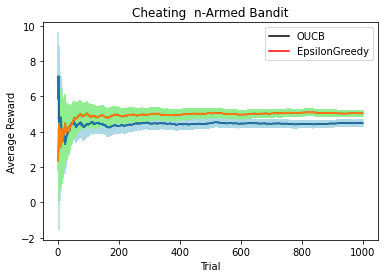

In [111]:
x = np.linspace(1, 1000, 1000)
plt.plot(x, cheater_mr_nobody_rewards_average, color="black")
plt.errorbar(x, cheater_mr_nobody_rewards_average, yerr=cheater_mr_nobody_errors, ecolor='lightblue')
plt.plot(x, self_mr_nobody_rewards_average, color="red")
plt.errorbar(x, self_mr_nobody_rewards_average, yerr=self_mr_nobody_errors, ecolor='lightgreen')
plt.xlabel("Trial")
plt.ylabel("Average Reward")
plt.title("Cheating  n-Armed Bandit")
plt.legend(['OUCB', 'EpsilonGreedy'])
plt.savefig("figs/1B4.jpg")
plt.show()

In [110]:
cmnra = cheater_mr_nobody.get_rewards_average()
cmnerr = 1.96 * cheater_mr_nobody.get_std() / np.sqrt(1000)
smnra = self_mr_nobody.get_rewards_average()
smnerr = 1.96 * self_mr_nobody.get_std() / np.sqrt(1000)

print("95% Confidence Interval of OUCB: ", cmnra - cmnerr, cmnra + cmnerr)
print("95% Confidence Interval of EpsilonGreedy: ", smnra - smnerr, smnra + smnerr)

95% Confidence Interval of OUCB:  4.2771850181356434 4.692045341452081
95% Confidence Interval of EpsilonGreedy:  4.839300097578807 5.237487230681811


### Question #3

#### Part A

In [282]:
class ArrayReward(RewardBase):
    def __init__(self, arr):
        super(ArrayReward, self).__init__()
        self.arr = arr
        self.i = 0

    def get_reward(self):
        row = self.arr[self.i]
        self.i += 1
        self.i = self.i % len(self.arr)
        return 2 * row[0] - row[1]

In [284]:
table = pd.read_csv("Q3.csv")
rewards = []
rewards.append(ArrayReward(np.array(table[["adidas 1", "cost of adidas 1"]])))
rewards.append(ArrayReward(np.array(table[["adidas 2", "cost of adidas 2"]])))
rewards.append(ArrayReward(np.array(table[["adidas 3", "cost of adidas 3"]])))
rewards.append(ArrayReward(np.array(table[["Nike 1", "cost of Nike 1"]])))
rewards.append(ArrayReward(np.array(table[["Nike 2", "cost of Nike 2"]])))
rewards.append(ArrayReward(np.array(table[["Nike 3", "cost of Nike 3"]])))

Q3env = MutliArmedBanditEnvironment(rewards, 3000, '1')

In [303]:
class LearningComparisonPolicy():
    def __init__(self, beta, taw):
        self.probs = []
        self.beta = beta
        self.taw = taw
    
    def softmax(self, actions, preferences):
        m = np.max(preferences)
        self.probs = []
        for i in range(actions):
            _p = preferences[i] / self.taw
            self.probs.append(np.exp(_p - m))
        self.probs /= np.sum(self.probs)
        return self.probs
    
    def get_action(self, actions, preferences):
        return np.random.choice(actions, p=self.softmax(actions, preferences))
    
    def update_preferences(self, preferences,  action, reward, rewards_average):
        preferences[action] = preferences[action] + self.beta * (reward - rewards_average)
        return preferences


In [310]:
class LearningComparisonAgent(AgentBase):
    def __init__(self, id, env, alpha, beta, taw):
        super(LearningComparisonAgent, self).__init__(id, env)
        self.actions = self.environment.available_actions()
        self.preferences = [0.0 for col in range(self.actions)]
        self.rewards_average = 0.0
        self.alpha = alpha
        self.beta = beta
        self.taw = taw
        self.policy = LearningComparisonPolicy(beta, taw)
    
    def take_action(self) -> (object, float, bool, object):
        action = self.policy.get_action(self.actions, self.preferences)
        obs, r, d, i = self.environment.step(action)
        self.rewards_average = (1 - self.alpha) * self.rewards_average + self.alpha * r
        self.preferences = self.policy.update_preferences(self.preferences, action, r, self.rewards_average)
        self.environment.render()
        return obs, r, d, i
    
    def reset(self):
        self.preferences = [0.0 for col in range(self.actions)]
        self.rewards_average = 0.0
    
    def get_rewards_average(self):
        return self.rewards_average

In [313]:
alpha = 0.9
beta = 0.1
taw = 10

learning_comparison_agent = LearningComparisonAgent('1', Q3env, alpha, beta, taw)
learning_comparison_rewards_average = []

for i in range(1000):
    learning_comparison_agent.take_action()
    learning_comparison_rewards_average.append(learning_comparison_agent.get_rewards_average())
env.reset()

5004:	action=0
5005:	action=3
5006:	action=0
5007:	action=2
5008:	action=3
5009:	action=0
5010:	action=3
5011:	action=0
5012:	action=3
5013:	action=1
5014:	action=1
5015:	action=5
5016:	action=4
5017:	action=2
5018:	action=2
5019:	action=1
5020:	action=5
5021:	action=1
5022:	action=0
5023:	action=0
5024:	action=2
5025:	action=0
5026:	action=2
5027:	action=4
5028:	action=1
5029:	action=2
5030:	action=1
5031:	action=3
5032:	action=3
5033:	action=4
5034:	action=1
5035:	action=1
5036:	action=2
5037:	action=2
5038:	action=3
5039:	action=2
5040:	action=2
5041:	action=4
5042:	action=0
5043:	action=0
5044:	action=2
5045:	action=0
5046:	action=1
5047:	action=3
5048:	action=2
5049:	action=2
5050:	action=1
5051:	action=2
5052:	action=2
5053:	action=4
5054:	action=1
5055:	action=1
5056:	action=0
5057:	action=1
5058:	action=2
5059:	action=1
5060:	action=1
5061:	action=1
5062:	action=4
5063:	action=2
5064:	action=1
5065:	action=0
5066:	action=1
5067:	action=1
5068:	action=1
5069:	action=1
5070:	acti

5628:	action=1
5629:	action=1
5630:	action=1
5631:	action=1
5632:	action=1
5633:	action=1
5634:	action=1
5635:	action=1
5636:	action=1
5637:	action=1
5638:	action=1
5639:	action=1
5640:	action=1
5641:	action=1
5642:	action=1
5643:	action=1
5644:	action=1
5645:	action=1
5646:	action=1
5647:	action=1
5648:	action=1
5649:	action=1
5650:	action=1
5651:	action=1
5652:	action=1
5653:	action=1
5654:	action=1
5655:	action=1
5656:	action=1
5657:	action=1
5658:	action=1
5659:	action=1
5660:	action=1
5661:	action=1
5662:	action=1
5663:	action=1
5664:	action=1
5665:	action=1
5666:	action=1
5667:	action=1
5668:	action=1
5669:	action=1
5670:	action=1
5671:	action=1
5672:	action=1
5673:	action=1
5674:	action=1
5675:	action=1
5676:	action=1
5677:	action=1
5678:	action=1
5679:	action=1
5680:	action=1
5681:	action=1
5682:	action=1
5683:	action=1
5684:	action=1
5685:	action=1
5686:	action=1
5687:	action=1
5688:	action=1
5689:	action=1
5690:	action=1
5691:	action=1
5692:	action=1
5693:	action=1
5694:	acti

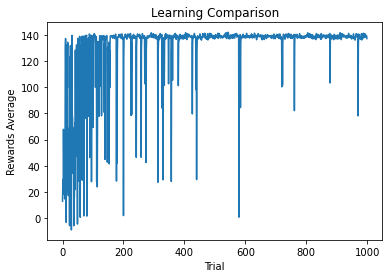

In [319]:
plt.plot(learning_comparison_rewards_average)
plt.xlabel("Trial")
plt.ylabel("Rewards Average")
plt.title("Learning Comparison")
plt.savefig("figs/3A.jpg")
plt.show()

#### Part B

In [327]:
m = np.max(table["adidas 2"] * 2 - table["cost of adidas 2"])

alpha = 0.9
beta = 0.1
taw = 10

learning_comparison_agent_r = LearningComparisonAgent('1', Q3env, alpha, beta, taw)
learning_comparison_regret = []

for j in range(1000):
    ob, r, d, i = learning_comparison_agent_r.take_action()
    if(j == 0):
        learning_comparison_regret.append(m-r)
    else:
        learning_comparison_regret.append(learning_comparison_regret[j - 1] + m - r)
env.reset()

8009:	action=3
8010:	action=3
8011:	action=1
8012:	action=5
8013:	action=4
8014:	action=1
8015:	action=1
8016:	action=3
8017:	action=5
8018:	action=2
8019:	action=1
8020:	action=1
8021:	action=3
8022:	action=0
8023:	action=0
8024:	action=5
8025:	action=4
8026:	action=1
8027:	action=1
8028:	action=1
8029:	action=0
8030:	action=5
8031:	action=3
8032:	action=1
8033:	action=2
8034:	action=1
8035:	action=5
8036:	action=5
8037:	action=1
8038:	action=1
8039:	action=0
8040:	action=0
8041:	action=1
8042:	action=0
8043:	action=1
8044:	action=1
8045:	action=1
8046:	action=1
8047:	action=5
8048:	action=4
8049:	action=1
8050:	action=1
8051:	action=1
8052:	action=4
8053:	action=0
8054:	action=5
8055:	action=4
8056:	action=1
8057:	action=4
8058:	action=4
8059:	action=1
8060:	action=5
8061:	action=1
8062:	action=1
8063:	action=4
8064:	action=1
8065:	action=1
8066:	action=4
8067:	action=2
8068:	action=1
8069:	action=1
8070:	action=1
8071:	action=1
8072:	action=1
8073:	action=1
8074:	action=1
8075:	acti

8556:	action=1
8557:	action=1
8558:	action=1
8559:	action=1
8560:	action=1
8561:	action=1
8562:	action=1
8563:	action=1
8564:	action=1
8565:	action=1
8566:	action=1
8567:	action=1
8568:	action=1
8569:	action=1
8570:	action=1
8571:	action=1
8572:	action=1
8573:	action=1
8574:	action=1
8575:	action=1
8576:	action=1
8577:	action=1
8578:	action=1
8579:	action=1
8580:	action=1
8581:	action=5
8582:	action=1
8583:	action=1
8584:	action=1
8585:	action=1
8586:	action=1
8587:	action=1
8588:	action=1
8589:	action=1
8590:	action=1
8591:	action=1
8592:	action=1
8593:	action=1
8594:	action=1
8595:	action=1
8596:	action=1
8597:	action=1
8598:	action=1
8599:	action=1
8600:	action=1
8601:	action=1
8602:	action=1
8603:	action=1
8604:	action=1
8605:	action=1
8606:	action=1
8607:	action=1
8608:	action=1
8609:	action=1
8610:	action=1
8611:	action=1
8612:	action=1
8613:	action=1
8614:	action=1
8615:	action=1
8616:	action=1
8617:	action=1
8618:	action=1
8619:	action=1
8620:	action=1
8621:	action=1
8622:	acti

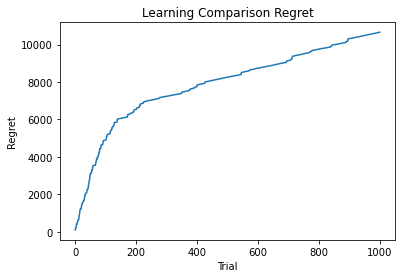

In [328]:
plt.plot(learning_comparison_regret)
plt.xlabel("Trial")
plt.ylabel("Regret")
plt.title("Learning Comparison Regret")
plt.savefig("figs/3B.jpg")
plt.show()

In [335]:
m = np.max(table["adidas 2"] * 2 - table["cost of adidas 2"])

taw = 10

learning_comparison_agent_28 = LearningComparisonAgent('1', Q3env, 0.2, 0.8, taw)
learning_comparison_regret_28 = []
learning_comparison_agent_82 = LearningComparisonAgent('1', Q3env, 0.8, 0.2, taw)
learning_comparison_regret_82 = []
learning_comparison_agent_55 = LearningComparisonAgent('1', Q3env, 0.5, 0.5, taw)
learning_comparison_regret_55 = []


for j in range(1000):
    ob, r, d, i = learning_comparison_agent_28.take_action()
    if(j == 0):
        learning_comparison_regret_28.append(m-r)
    else:
        learning_comparison_regret_28.append(learning_comparison_regret_28[j - 1] + m - r)
env.reset()

for j in range(1000): 
    ob, r, d, i = learning_comparison_agent_82.take_action()
    if(j == 0):
        learning_comparison_regret_82.append(m-r)
    else:
        learning_comparison_regret_82.append(learning_comparison_regret_82[j - 1] + m - r)
env.reset()

for j in range(1000): 
    ob, r, d, i = learning_comparison_agent_55.take_action()
    if(j == 0):
        learning_comparison_regret_55.append(m-r)
    else:
        learning_comparison_regret_55.append(learning_comparison_regret_55[j - 1] + m - r)
env.reset()


18009:	action=2
18010:	action=2
18011:	action=2
18012:	action=2
18013:	action=2
18014:	action=2
18015:	action=2
18016:	action=2
18017:	action=2
18018:	action=2
18019:	action=2
18020:	action=2
18021:	action=2
18022:	action=2
18023:	action=2
18024:	action=2
18025:	action=2
18026:	action=2
18027:	action=2
18028:	action=2
18029:	action=2
18030:	action=2
18031:	action=2
18032:	action=2
18033:	action=2
18034:	action=2
18035:	action=2
18036:	action=2
18037:	action=2
18038:	action=2
18039:	action=2
18040:	action=2
18041:	action=2
18042:	action=2
18043:	action=2
18044:	action=2
18045:	action=2
18046:	action=2
18047:	action=2
18048:	action=2
18049:	action=2
18050:	action=2
18051:	action=2
18052:	action=2
18053:	action=2
18054:	action=2
18055:	action=2
18056:	action=2
18057:	action=2
18058:	action=2
18059:	action=2
18060:	action=2
18061:	action=2
18062:	action=2
18063:	action=2
18064:	action=2
18065:	action=2
18066:	action=2
18067:	action=2
18068:	action=2
18069:	action=2
18070:	action=2
18071:	a

18635:	action=2
18636:	action=2
18637:	action=2
18638:	action=2
18639:	action=2
18640:	action=2
18641:	action=2
18642:	action=2
18643:	action=2
18644:	action=2
18645:	action=2
18646:	action=2
18647:	action=2
18648:	action=2
18649:	action=2
18650:	action=2
18651:	action=2
18652:	action=2
18653:	action=2
18654:	action=2
18655:	action=2
18656:	action=2
18657:	action=2
18658:	action=2
18659:	action=2
18660:	action=2
18661:	action=2
18662:	action=2
18663:	action=2
18664:	action=2
18665:	action=2
18666:	action=2
18667:	action=2
18668:	action=2
18669:	action=2
18670:	action=2
18671:	action=2
18672:	action=2
18673:	action=2
18674:	action=2
18675:	action=2
18676:	action=2
18677:	action=2
18678:	action=2
18679:	action=2
18680:	action=2
18681:	action=2
18682:	action=2
18683:	action=2
18684:	action=2
18685:	action=2
18686:	action=2
18687:	action=2
18688:	action=2
18689:	action=2
18690:	action=2
18691:	action=2
18692:	action=2
18693:	action=2
18694:	action=2
18695:	action=2
18696:	action=2
18697:	a

19236:	action=1
19237:	action=1
19238:	action=1
19239:	action=1
19240:	action=1
19241:	action=1
19242:	action=1
19243:	action=1
19244:	action=1
19245:	action=1
19246:	action=1
19247:	action=1
19248:	action=1
19249:	action=1
19250:	action=1
19251:	action=1
19252:	action=1
19253:	action=1
19254:	action=1
19255:	action=1
19256:	action=1
19257:	action=1
19258:	action=1
19259:	action=1
19260:	action=1
19261:	action=3
19262:	action=1
19263:	action=1
19264:	action=1
19265:	action=3
19266:	action=1
19267:	action=1
19268:	action=1
19269:	action=1
19270:	action=1
19271:	action=1
19272:	action=1
19273:	action=1
19274:	action=1
19275:	action=1
19276:	action=1
19277:	action=1
19278:	action=1
19279:	action=1
19280:	action=1
19281:	action=1
19282:	action=1
19283:	action=1
19284:	action=1
19285:	action=1
19286:	action=1
19287:	action=1
19288:	action=1
19289:	action=1
19290:	action=1
19291:	action=1
19292:	action=1
19293:	action=1
19294:	action=1
19295:	action=1
19296:	action=1
19297:	action=1
19298:	a

19807:	action=5
19808:	action=1
19809:	action=1
19810:	action=1
19811:	action=1
19812:	action=1
19813:	action=1
19814:	action=1
19815:	action=1
19816:	action=1
19817:	action=1
19818:	action=1
19819:	action=1
19820:	action=1
19821:	action=1
19822:	action=1
19823:	action=1
19824:	action=1
19825:	action=1
19826:	action=1
19827:	action=1
19828:	action=1
19829:	action=1
19830:	action=1
19831:	action=1
19832:	action=1
19833:	action=1
19834:	action=1
19835:	action=1
19836:	action=1
19837:	action=1
19838:	action=1
19839:	action=1
19840:	action=1
19841:	action=1
19842:	action=1
19843:	action=1
19844:	action=1
19845:	action=1
19846:	action=1
19847:	action=1
19848:	action=1
19849:	action=1
19850:	action=1
19851:	action=1
19852:	action=1
19853:	action=1
19854:	action=1
19855:	action=1
19856:	action=1
19857:	action=1
19858:	action=1
19859:	action=1
19860:	action=1
19861:	action=1
19862:	action=1
19863:	action=1
19864:	action=1
19865:	action=1
19866:	action=1
19867:	action=1
19868:	action=1
19869:	a

20395:	action=5
20396:	action=5
20397:	action=5
20398:	action=5
20399:	action=5
20400:	action=5
20401:	action=5
20402:	action=5
20403:	action=5
20404:	action=5
20405:	action=5
20406:	action=5
20407:	action=5
20408:	action=5
20409:	action=5
20410:	action=5
20411:	action=5
20412:	action=5
20413:	action=5
20414:	action=5
20415:	action=5
20416:	action=5
20417:	action=5
20418:	action=5
20419:	action=5
20420:	action=5
20421:	action=5
20422:	action=5
20423:	action=5
20424:	action=5
20425:	action=5
20426:	action=5
20427:	action=5
20428:	action=5
20429:	action=5
20430:	action=5
20431:	action=5
20432:	action=5
20433:	action=5
20434:	action=5
20435:	action=5
20436:	action=5
20437:	action=5
20438:	action=5
20439:	action=5
20440:	action=5
20441:	action=5
20442:	action=5
20443:	action=5
20444:	action=5
20445:	action=5
20446:	action=5
20447:	action=5
20448:	action=5
20449:	action=5
20450:	action=5
20451:	action=5
20452:	action=5
20453:	action=5
20454:	action=5
20455:	action=5
20456:	action=5
20457:	a

21002:	action=5
21003:	action=5
21004:	action=5
21005:	action=5
21006:	action=5
21007:	action=5
21008:	action=5


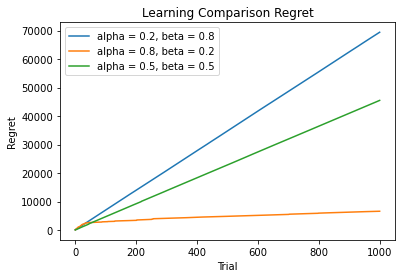

In [336]:
plt.plot(learning_comparison_regret_28)
plt.plot(learning_comparison_regret_82)
plt.plot(learning_comparison_regret_55)
plt.xlabel("Trial")
plt.ylabel("Regret")
plt.title("Learning Comparison Regret")
plt.legend(["alpha = 0.2, beta = 0.8",  "alpha = 0.8, beta = 0.2", "alpha = 0.5, beta = 0.5"])
plt.savefig("figs/3BComp.jpg")
plt.show()